# 06 · Model-Ready Feature Pipeline

We integrate and preprocess the feature matrix for modelling with the data tables produced in previous notebooks.

In [ ]:
# Core imports and helper bindings
from pathlib import Path
import sys
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

RESULTS_DIR = PROJECT_ROOT / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR = RESULTS_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

MODEL_RESULTS_DIR = RESULTS_DIR / 'modeling'
MODEL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = PROJECT_ROOT / 'data'
MODEL_READY_DIR = DATA_DIR / '2-model-ready'
MODEL_READY_DIR.mkdir(parents=True, exist_ok=True)

from src.model_preprocessing import (
    FEATURE_GROUPS,
    DATASET_SPECS,
    LOG1P_FEATURES,
    WINSOR_FEATURES,
    ADD_MISSING_INDICATORS,
    SELECTED_FEATURES,
    load_dataset,
    merge_tables,
    coerce_types,
    compute_citywise_zscores,
    add_derived_features,
    apply_value_transforms,
    select_feature_columns,
    impute_by_city,
    scale_within_city,
    add_neighbor_context_features,
    build_feature_summary,
    load_processed_sources,
    run_preprocessing_pipeline,
    HIGH_CORRELATION_THRESHOLD,
)
from src.plotting_utils import load_grid_geodataframe

In [2]:
# Cell 4: Dataset summary helper
def create_dataset_summary(df, feature_groups):
    """Create a dissertation-ready dataset overview."""
    record_count = len(df)
    city_counts = df['city'].value_counts().rename('grid_cells')
    targets = {
        'mean_LST (°C)': 'target_lst_mean_celsius',
        'UHI (°C)': 'target_uhi_raw',
    }

    city_stats = pd.DataFrame({'city': city_counts.index})
    city_stats['grid_cells'] = city_counts.values
    city_stats['share_of_total_%'] = (city_stats['grid_cells'] / record_count * 100).round(2)

    for label, col in targets.items():
        if col in df.columns:
            city_stats[label] = df.groupby('city')[col].mean().round(2).reindex(city_stats['city']).values
        else:
            city_stats[label] = np.nan

    city_stats['grid_cells'] = city_stats['grid_cells'].map(lambda x: f"{x:,}")

    feature_summary = pd.DataFrame({
        'metric': ['Observations', 'Cities', 'Features (total)'],
        'value': [f"{record_count:,}", df['city'].nunique(), df.shape[1]],
    })

    group_counts = (
        pd.DataFrame([
            {'feature_group': group, 'feature_count': len([f for f in members if f in df.columns])}
            for group, members in feature_groups.items()
        ])
        .sort_values('feature_count', ascending=False)
        .reset_index(drop=True)
    )

    return feature_summary, city_stats, group_counts


## 1. Load processed sources

In [3]:
source_tables, provenance = load_processed_sources(PROJECT_ROOT)
column_sources: Dict[str, str] = {}
summary = []

for name, table in source_tables.items():
    column_sources.update(provenance.get(name, {}))
    summary.append({
        'dataset': name,
        'rows': len(table),
        'columns': len(table.columns),
        'cities': table['city'].nunique() if 'city' in table.columns else '—',
    })
    print(f"{name:<15s}: {len(table):>6} rows × {len(table.columns):>3} cols")
    display(table.head(3))

pd.DataFrame(summary)


buildings      :  40344 rows ×  32 cols


,city,global_grid_id,bld_grid_size_m,bld_building_count,bld_total_footprint_area,bld_total_wall_surface_area,bld_far,bld_bvd,bld_area_weighted_height,bld_building_coverage_ratio,...,bld_facade_orientation_entropy,bld_canyon_width_mean,bld_courtyard_fraction,bld_area_weighted_building_year,bld_age_pre1950_share,bld_age_1950_1990_share,bld_age_post1990_share,bld_frontal_area_density_ns,bld_frontal_area_density_ew,bld_has_buildings
0,Amsterdam,Amsterdam_0,30,2,71.013628,1032.160385,1.267368,4.137170,19.586274,0.210827,...,0.587953,6.051201,0.0,1884.0,1.0,0.0,0.0,3.070132,0.0,True
1,Amsterdam,Amsterdam_1,30,2,141.956277,1094.481447,2.533488,8.284893,19.620913,0.421995,...,0.113328,11.810765,0.0,1884.0,1.0,0.0,0.0,3.255528,0.0,True
2,Amsterdam,Amsterdam_2,30,2,11.340428,350.222655,0.168661,0.547099,16.218864,0.033655,...,-0.000000,2.369036,0.0,1870.0,1.0,0.0,0.0,1.041743,0.0,True


streetscapes   :  40344 rows ×  19 cols


,city,global_grid_id,ss_grid_size_m,ss_image_count,ss_building_mean,ss_road_mean,ss_sidewalk_mean,ss_vegetation_mean,ss_sky_mean,ss_water_mean,ss_beautiful_mean,ss_safe_mean,ss_wealthy_mean,ss_lively_mean,ss_boring_mean,ss_depressing_mean,ss_green_view_index_mean,ss_sky_view_index_mean,ss_has_streetscape_data
0,Amsterdam,Amsterdam_0,30,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.00,0.00,0.000000,0.000000,False
1,Amsterdam,Amsterdam_1,30,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.00,0.00,0.000000,0.000000,False
2,Amsterdam,Amsterdam_2,30,2.0,0.219807,0.016392,0.048915,0.071815,0.285948,0.0,7.955,2.56,5.33,7.235,2.95,3.21,0.071815,0.285948,True


urbanity       :  40344 rows ×  26 cols


,global_grid_id,city,urb_grid_size_m,urb_node_count,urb_edge_count,urb_street_length,urb_network_degree,urb_network_betweenness,urb_network_closeness,urb_population_popsum_density,...,urb_streetview_sky_view,urb_streetview_building_view,urb_streetview_road_view,urb_streetview_visual_complexity_mean,urb_street_orientation_index,urb_meshedness,urb_connectivity_beta,urb_canyon_ratio,urb_intersection_density,urb_has_network_data
0,Amsterdam_0,Amsterdam,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Amsterdam_1,Amsterdam,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Amsterdam_2,Amsterdam,30,1.0,6.0,62.027513,3.0,0.002,0.024,0.398889,...,0.134056,0.353332,0.129186,1.7008,0.533619,0.0,6.0,2.635692,0.001111,True


gee            :  40344 rows ×  61 cols


,gee_evi,gee_lst_day_mean,gee_lst_day_night_delta,gee_lst_max,gee_lst_mean,gee_lst_night_mean,gee_lst_p90,gee_lst_range,gee_lst_std,gee_mndwi,...,gee_impervious_fraction_150m,gee_impervious_fraction_300m,gee_vegetation_fraction_90m,gee_vegetation_fraction_150m,gee_vegetation_fraction_300m,gee_lst_city_median,gee_lst_city_std,gee_uhi_intensity_sigma,gee_uhi_sigma_threshold,gee_uhi_hotspot_flag
0,0.146669,33.525539,18.601469,39.153823,33.525539,14.924070,39.107408,12.345608,4.458954,-0.253589,...,0.888501,0.732473,1.0,1.0,0.910394,32.23539,1.263199,1.021334,33.49859,1
1,0.138769,33.784467,18.860297,39.690859,33.784467,14.924170,39.652263,12.867896,4.575844,-0.287697,...,0.867806,0.768150,1.0,1.0,0.875576,32.23539,1.263199,1.226312,33.49859,1
2,0.191858,33.843488,18.919279,39.841903,33.843488,14.924209,39.808183,13.048595,4.613969,-0.321095,...,0.795553,0.796372,1.0,1.0,0.849462,32.23539,1.263199,1.273036,33.49859,1


voxcity        :  40344 rows ×  35 cols


,city,global_grid_id,vox_grid_size_m,vox_svf,vox_gvi,vox_solar,vox_solar_daily_summer,vox_solar_winter_peak,vox_solar_direct,vox_solar_diffuse,...,vox_canopy_thickness_mean,vox_built_up_ratio,vox_tree_canopy_ratio,vox_building_volume_sum,vox_canopy_volume_sum,vox_thermal_mass_index,vox_canyon_aspect_ratio,vox_landcover_impervious_ratio,vox_landcover_vegetation_ratio,vox_grid_resolution_m
0,Amsterdam,Amsterdam_0,30,0.761316,0.009119,794.674974,6224.000824,51.141262,692.820323,152.263109,...,0.102853,0.6250,0.00,2449.0575,0.000000,206896377.6,1.96221,1.0,0.0,30
1,Amsterdam,Amsterdam_1,30,0.669688,0.007554,781.537394,6118.900187,46.408469,692.820323,133.937553,...,0.370270,0.1500,0.20,1470.4225,20.570571,124221292.8,1.96221,1.0,0.0,30
2,Amsterdam,Amsterdam_2,30,0.708792,0.011326,782.598238,6127.386940,46.790637,692.820323,141.758304,...,0.077140,0.1875,0.75,0.0000,10.285285,0.0,0.17919,1.0,0.0,30


,dataset,rows,columns,cities
0,buildings,40344,32,6
1,streetscapes,40344,19,6
2,urbanity,40344,26,6
3,gee,40344,61,6
4,voxcity,40344,35,6


## 2. Merge tables & normalise dtypes

In [4]:
merged = merge_tables(source_tables.values())
merged = coerce_types(merged)
print(f"Merged shape: {merged.shape}")
merged[['city', 'global_grid_id']].head()


Merged shape: (40344, 165)


,city,global_grid_id
0,Amsterdam,Amsterdam_0
1,Amsterdam,Amsterdam_1
2,Amsterdam,Amsterdam_10
3,Amsterdam,Amsterdam_100
4,Amsterdam,Amsterdam_1000


## 3. Target engineering

In [5]:
merged_targets = merged.copy()
if 'gee_lst_mean' not in merged_targets:
    raise KeyError("Missing 'gee_lst_mean'")

merged_targets['target_lst_mean_celsius'] = merged_targets['gee_lst_mean']
zscores, target_stats = compute_citywise_zscores(merged_targets, 'gee_lst_mean')
merged_targets['target_lst_mean_zscore'] = zscores
city_medians = merged_targets.groupby('city')['gee_lst_mean'].transform('median')
merged_targets['target_uhi_raw'] = merged_targets['gee_lst_mean'] - city_medians

print('Target stats sample:')
display(target_stats.head())
merged_targets[['city', 'gee_lst_mean', 'target_lst_mean_celsius', 'target_lst_mean_zscore', 'target_uhi_raw']].head()


Target stats sample:


,city,city_mean,city_std
0,Amsterdam,32.301625,1.263199
1,Athens,45.836279,1.220634
2,Barcelona,39.322524,3.134018
3,Berlin,33.747855,1.266952
4,Madrid,37.912858,2.886677


,city,gee_lst_mean,target_lst_mean_celsius,target_lst_mean_zscore,target_uhi_raw
0,Amsterdam,33.525539,33.525539,0.968900,1.290149
1,Amsterdam,33.784467,33.784467,1.173877,1.549077
2,Amsterdam,34.091720,34.091720,1.417111,1.856330
3,Amsterdam,31.907458,31.907458,-0.312039,-0.327933
4,Amsterdam,35.242103,35.242103,2.327802,3.006713


Targets produce raw °C, within-city z-scores, and city-relative anomalies.

### 3.1 Target Distribution Analysis

Analyse the distribution of UHI intensity across the six study cities to understand thermal variation patterns.

UHI Intensity Statistics by City:


,Mean (°C),Std Dev (°C),Min (°C),Max (°C),Range (°C)
city,,,,,
Amsterdam,0.07,1.26,-3.50,3.46,6.96
Athens,0.18,1.22,-4.18,4.08,8.26
Barcelona,-0.85,3.13,-13.16,2.88,16.04
Berlin,-0.14,1.27,-5.36,3.35,8.71
Madrid,-0.20,2.89,-8.71,6.36,15.07
Paris,-0.62,1.88,-9.10,2.76,11.86


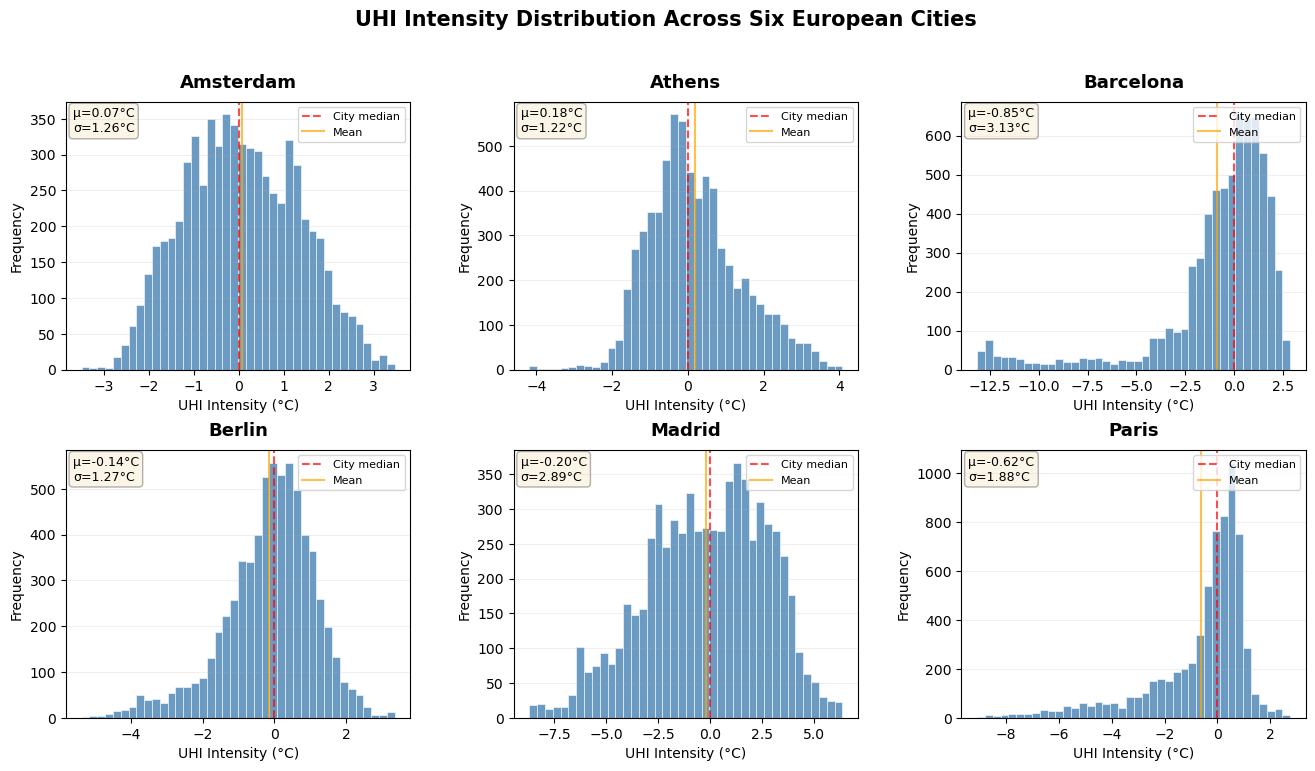

Saved figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/uhi_target_distribution_panels.png

Dataset-wide UHI statistics:
  Total observations: 40,344
  Mean UHI: -0.261°C
  Std Dev: 2.128°C
  Range: -13.16°C to 6.36°C


In [6]:
# UHI distribution analysis by city
import seaborn as sns

CITIES = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Madrid', 'Paris']

# Create summary statistics table
uhi_stats = merged_targets.groupby('city')['target_uhi_raw'].agg([
    ('Mean (°C)', 'mean'),
    ('Std Dev (°C)', 'std'),
    ('Min (°C)', 'min'),
    ('Max (°C)', 'max'),
    ('Range (°C)', lambda x: x.max() - x.min())
]).round(2)

print("UHI Intensity Statistics by City:")
display(uhi_stats)

# Cleaner visualization: Combined histogram + boxplot
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

for i, city in enumerate(CITIES):
    city_data = merged_targets[merged_targets['city'] == city]['target_uhi_raw']
    
    # Histogram
    ax = fig.add_subplot(gs[i // 3, i % 3])
    ax.hist(city_data, bins=40, edgecolor='white', alpha=0.8, color='steelblue', linewidth=0.5)
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='City median')
    ax.axvline(city_data.mean(), color='orange', linestyle='-', linewidth=1.5, alpha=0.7, label='Mean')
    
    ax.set_title(f"{city}", fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('UHI Intensity (°C)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(alpha=0.2, axis='y')
    
    # Add text box with stats
    stats_text = f"μ={city_data.mean():.2f}°C\nσ={city_data.std():.2f}°C"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('UHI Intensity Distribution Across Six European Cities', fontsize=15, fontweight='bold', y=0.995)
fig_path = FIG_DIR / 'uhi_target_distribution_panels.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved figure to {fig_path}')

# Overall statistics
print(f"\nDataset-wide UHI statistics:")
print(f"  Total observations: {len(merged_targets):,}")
print(f"  Mean UHI: {merged_targets['target_uhi_raw'].mean():.3f}°C")
print(f"  Std Dev: {merged_targets['target_uhi_raw'].std():.3f}°C")
print(f"  Range: {merged_targets['target_uhi_raw'].min():.2f}°C to {merged_targets['target_uhi_raw'].max():.2f}°C")


These three target variants underpin the modelling + reporting pipeline.

Targets: raw LST, within-city z-score, and city-relative UHI anomaly support modelling/interpretation.

## 4. Derived features, transforms, neighbour context
Apply physics-inspired derivatives, log/winsor transforms, and optional neighbourhood context.

### Neighbor Context Methodology

**Spatial aggregation rationale:**  
Urban microclimate is influenced by features beyond the immediate grid cell. We compute neighborhood aggregations (mean, std) at two spatial scales:

- **150m radius**: Pedestrian perception scale, capturing immediate street-level context (Ewing & Handy 2009; Gehl 2011). This distance approximates the "walkable zone" where thermal comfort is most directly experienced.
- **300m radius**: Neighborhood morphological scale, capturing block-level patterns that influence airflow and radiative exchange (Stewart & Oke 2012; Oke et al. 2017). This scale aligns with typical Local Climate Zone (LCZ) dimensions.

**Features aggregated:**  
We focus on impervious surface fraction, tree canopy cover, and vegetation fraction—features with established links to surface temperature modulation (Rizwan et al. 2008; Buyantuyev & Wu 2010):
- **Impervious fraction**: Captures thermal mass and heat retention potential
- **Tree canopy**: Provides shading and evapotranspiration cooling
- **Vegetation fraction**: Combined greenness signal for evaporative cooling
- **Ventilation proxy**: Derived feature capturing potential airflow patterns

**Implementation:** BallTree spatial index with haversine distance metric ensures accurate geographic distance calculations across all six European cities.

In [7]:
grid_gdf = load_grid_geodataframe()
if grid_gdf.crs is None:
    grid_gdf = grid_gdf.set_crs('EPSG:3857')
grid_metric = grid_gdf.to_crs('EPSG:3857').copy()
centroids = grid_metric.geometry.centroid
grid_metric['x'] = centroids.x
grid_metric['y'] = centroids.y
grid_coords = grid_metric[["global_grid_id", "x", "y"]]

targets_with_coords = merged_targets.merge(grid_coords, on='global_grid_id', how='left')
features_derived, column_sources = add_derived_features(targets_with_coords, column_sources)
features_transformed = apply_value_transforms(features_derived)

neighbor_specs = [
    ('gee_impervious_fraction', 150.0, 'mean'),
    ('gee_impervious_fraction', 150.0, 'std'),
    ('gee_impervious_fraction', 300.0, 'mean'),
    ('gee_tree_canopy_cover', 150.0, 'mean'),
    ('gee_tree_canopy_cover', 300.0, 'mean'),
    ('gee_vegetation_fraction', 150.0, 'mean'),
    ('gee_vegetation_fraction', 300.0, 'mean'),
    ('derived_ventilation_proxy', 150.0, 'mean'),
]
features_neighbour, column_sources = add_neighbor_context_features(
    features_transformed,
    column_sources,
    specs=neighbor_specs,
    city_col='city',
)
print('Columns after neighbour context:', len(features_neighbour.columns))
features_neighbour.head(2)


Columns after neighbour context: 189


,city,global_grid_id,bld_grid_size_m,bld_building_count,bld_total_footprint_area,bld_total_wall_surface_area,bld_far,bld_bvd,bld_area_weighted_height,bld_building_coverage_ratio,...,derived_vegetation_cooling_saturation,derived_canyon_sky_openness,gee_impervious_fraction_neighbor_mean_150m,gee_impervious_fraction_neighbor_std_150m,gee_impervious_fraction_neighbor_mean_300m,gee_tree_canopy_cover_neighbor_mean_150m,gee_tree_canopy_cover_neighbor_mean_300m,gee_vegetation_fraction_neighbor_mean_150m,gee_vegetation_fraction_neighbor_mean_300m,derived_ventilation_proxy_neighbor_mean_150m
0,Amsterdam,Amsterdam_0,30,2,71.013628,1032.160385,1.267368,4.137170,19.586274,0.210827,...,2.278280,0.406139,0.688214,0.295808,0.849836,0.186731,0.078658,1.00000,0.803146,0.283975
1,Amsterdam,Amsterdam_1,30,2,141.956277,1094.481447,2.533488,8.284893,19.620913,0.421995,...,2.215429,0.406139,0.696038,0.293086,0.834377,0.165299,0.091733,0.97957,0.784972,0.267848


### 4.2 Non-Linear Physics Features

**Challenge:** Simple interaction features (products) were removed by correlation filter due to |r| > 0.92 with existing linear features.



In [8]:
# Add key non-linear physics features for UHI, decorrelated from linear terms

# 1. Heat trap ratio (impervious / albedo, not product)
features_neighbour['derived_urban_heat_trap_index'] = (
    features_neighbour['gee_impervious_fraction_300m'].fillna(0)
    / (features_neighbour['gee_albedo'].fillna(0.3) + 0.1)
)  # ratio: absorption vs reflection

# 2. Veg cooling saturation (log-ratio, diminishing returns)
features_neighbour['derived_vegetation_cooling_saturation'] = (
    np.log1p(features_neighbour['gee_vegetation_fraction_300m'].fillna(0)*10)
    / (np.log1p(features_neighbour['gee_impervious_fraction_300m'].fillna(0)+1)+0.01)
)  # log-ratio: reduces linear veg/imp correlation

# 3. Sky openness (1/canyon ratio, for radiative cooling)
features_neighbour['derived_canyon_sky_openness'] = (
    1.0 / (features_neighbour['vox_canyon_aspect_ratio'].fillna(0) + 0.5)
)  # reciprocal: decorrelate canyon_aspect_ratio

# 4. Impervious spatial contrast: local std/mean (spatial heterogeneity)
features_neighbour['derived_impervious_spatial_contrast'] = (
    features_neighbour['gee_impervious_fraction_neighbor_std_150m'].fillna(0)
    / (features_neighbour['gee_impervious_fraction_neighbor_mean_300m'].fillna(0) + 0.1)
)  # local std/mean: edge effect proxy

column_sources['derived_urban_heat_trap_index'] = 'derived'
column_sources['derived_vegetation_cooling_saturation'] = 'derived'
column_sources['derived_canyon_sky_openness'] = 'derived'
column_sources['derived_impervious_spatial_contrast'] = 'derived'

print(f"Features after non-linear engineering: {len(features_neighbour.columns)}")

nonlinear_features = [
    'derived_urban_heat_trap_index',
    'derived_vegetation_cooling_saturation',
    'derived_canyon_sky_openness',
    'derived_impervious_spatial_contrast'
]
print("Added non-linear features:")
for feat in nonlinear_features:
    print(f"  - {feat}")

print("UHI corr (before scaling):")
for feat in nonlinear_features:
    print(f"{feat:40s} r = {features_neighbour[[feat, 'target_uhi_raw']].corr().iloc[0,1]:6.3f}")

Features after non-linear engineering: 190
Added non-linear features:
  - derived_urban_heat_trap_index
  - derived_vegetation_cooling_saturation
  - derived_canyon_sky_openness
  - derived_impervious_spatial_contrast
UHI corr (before scaling):
derived_urban_heat_trap_index            r =  0.367
derived_vegetation_cooling_saturation    r = -0.143
derived_canyon_sky_openness              r = -0.302
derived_impervious_spatial_contrast      r = -0.271


In [9]:
# Run preprocessing pipeline once for downstream diagnostics and exports
qa_dataset, qa_artifacts = run_preprocessing_pipeline(PROJECT_ROOT, return_artifacts=True)
print(f"Correlation-filtered feature count: {len(qa_dataset.feature_columns)}")


Removed 47 highly correlated features (abs(r) > 0.92).
Correlation-filtered feature count: 118


### 4.1 Feature-Target Relationships

Identify which features have the strongest correlation with UHI intensity to guide model interpretation.

Top 15 features correlated with UHI intensity:


,Feature,Correlation
0,gee_impervious_fraction_300m,0.579
1,gee_impervious_fraction_neighbor_mean_300m,0.542
2,derived_urban_heat_trap_index,0.461
3,gee_builtup_fraction_remote,0.457
4,gee_ndbi,0.450
5,gee_albedo,0.435
6,gee_water_fraction,-0.421
7,gee_emissivity_std,-0.419
8,gee_distance_to_water,0.389
9,gee_distance_to_coast,0.337


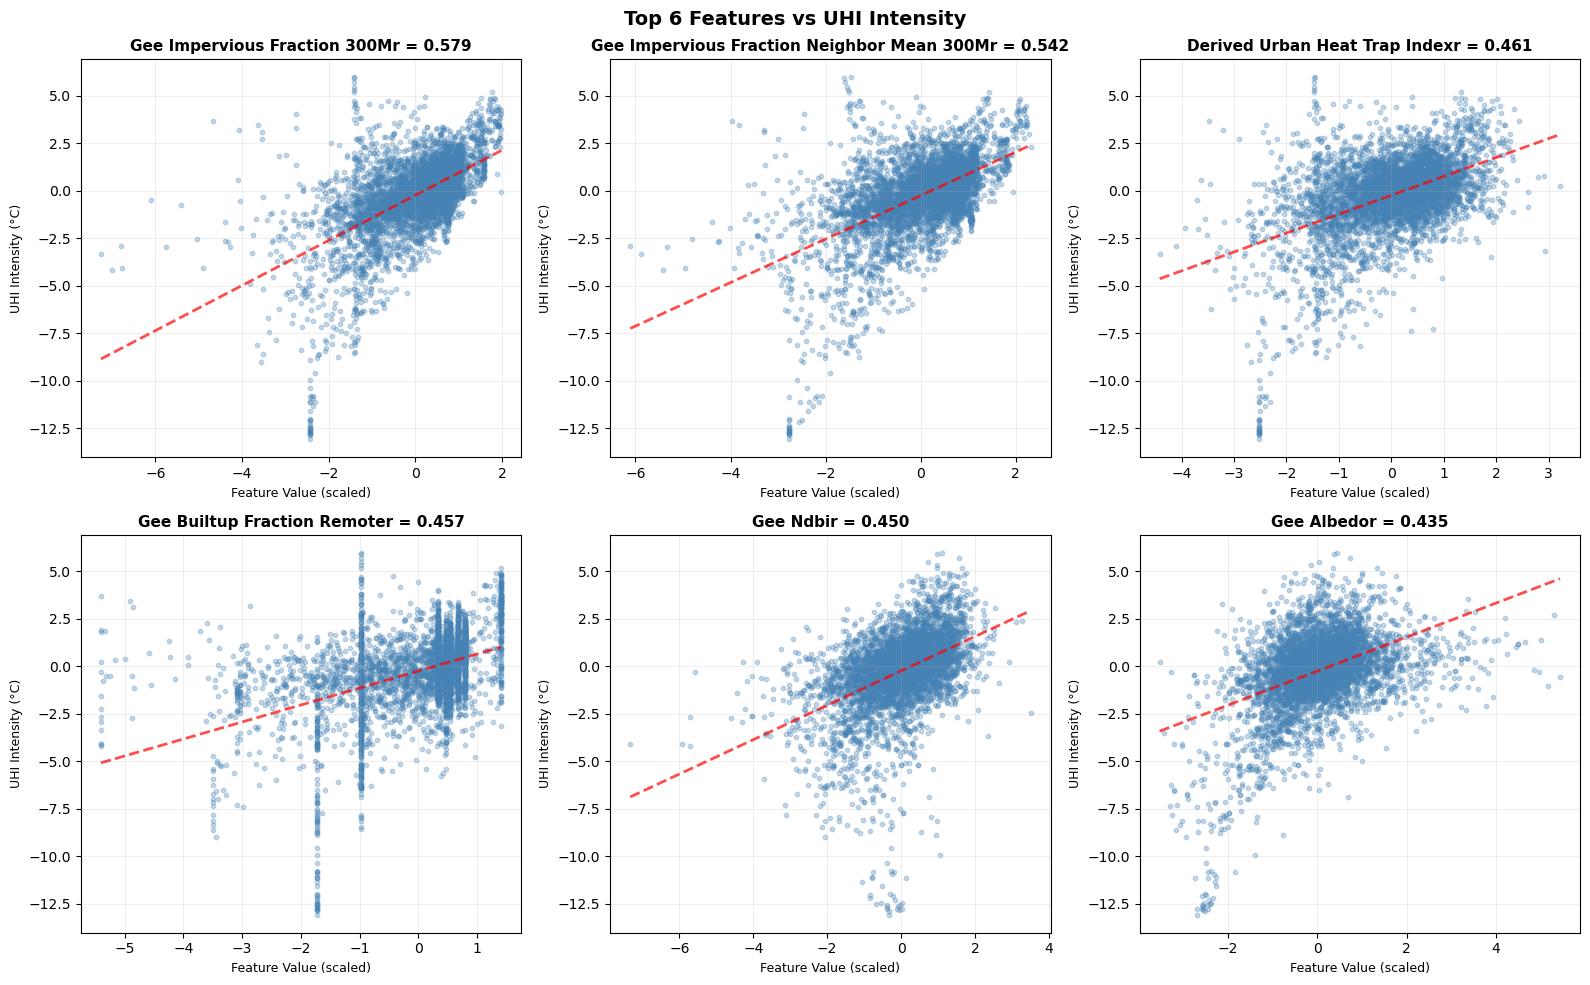

Saved figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/top_features_vs_uhi.png
Feature importance by category:
Remote Sensing         14
Derived Features        3
Building Morphology     2
VoxCity 3D              1
Name: count, dtype: int64


In [10]:
# Compute correlations between scaled features and UHI target using cached pipeline output
feature_cols = qa_dataset.feature_columns

# Compute correlations
correlations = qa_dataset.frame[feature_cols + ['target_uhi_raw']].corr()['target_uhi_raw'].drop('target_uhi_raw')
correlations = correlations.sort_values(key=abs, ascending=False)

# Top 15 features
top_features = correlations.head(15)
print(f"Top 15 features correlated with UHI intensity:")
display(pd.DataFrame({
    'Feature': [f.replace('_scaled', '') for f in top_features.index],
    'Correlation': top_features.values
}).round(3))

# Visualization: Scatter plots for top 6 features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
top_6_features = correlations.head(6)

for i, (feat, corr) in enumerate(top_6_features.items()):
    ax = axes.flat[i]

    # Sample 5000 points for clearer visualization
    sample = qa_dataset.frame.sample(n=min(5000, len(qa_dataset.frame)), random_state=42)

    ax.scatter(sample[feat], sample['target_uhi_raw'], alpha=0.3, s=10, c='steelblue')

    # Add regression line
    z = np.polyfit(sample[feat], sample['target_uhi_raw'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample[feat].min(), sample[feat].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.7, linewidth=2)

    # Clean feature name for title
    clean_name = feat.replace('_scaled', '').replace('_', ' ').title()
    ax.set_title(f"{clean_name}r = {corr:.3f}", fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature Value (scaled)', fontsize=9)
    ax.set_ylabel('UHI Intensity (°C)', fontsize=9)
    ax.grid(alpha=0.2)

plt.suptitle('Top 6 Features vs UHI Intensity', fontsize=14, fontweight='bold')
plt.tight_layout()
fig_path = FIG_DIR / 'top_features_vs_uhi.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved figure to {fig_path}')

# Feature category analysis
print("Feature importance by category:")
category_mapping = {
    'gee_': 'Remote Sensing',
    'bld_': 'Building Morphology',
    'vox_': 'VoxCity 3D',
    'urb_': 'Urbanity',
    'ss_': 'Street View',
    'derived_': 'Derived Features'
}

def categorize_feature(feat_name):
    for prefix, category in category_mapping.items():
        if feat_name.startswith(prefix):
            return category
    return 'Other'

top_20 = correlations.head(20)
category_counts = pd.Series([categorize_feature(f) for f in top_20.index]).value_counts()
print(category_counts)



## 5. Feature selection & missingness

In [11]:
candidate_features = select_feature_columns(features_neighbour.columns)
missing_counts = features_neighbour[candidate_features].isna().sum().sort_values(ascending=False)
missing_counts.head(10)

missing_counts_path = MODEL_RESULTS_DIR / 'missing_counts_by_feature.csv'
missing_counts.to_frame(name='missing_count').to_csv(missing_counts_path)
print(f"Saved missing-count table to {missing_counts_path}")

Saved missing-count table to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/missing_counts_by_feature.csv


### 5.1 Missing Value Patterns

Visualize city-specific missingness rates and document the imputation strategy to justify choices made in Section 6.

In [12]:
# City-specific missingness heatmap for top 10 features
missing_by_city = features_neighbour.groupby('city')[candidate_features].apply(
    lambda x: x.isna().sum() / len(x) * 100
)
top_missing = missing_by_city.max(axis=0).sort_values(ascending=False).head(10).index

# Imputation strategy table
# Define skip columns (features excluded from median imputation)
skip_columns = [
    'bld_area_weighted_building_year',
    'bld_age_pre1945', 'bld_age_1945_1969', 'bld_age_1970_1989',
    'bld_age_1990_1999', 'bld_age_2000_2009', 'bld_age_2010_2014', 'bld_age_post2015',
    'urb_streetview_green_view', 'urb_streetview_sky_view', 
    'urb_streetview_building_view', 'urb_streetview_road_view',
    'urb_streetview_visual_complexity_mean',
]

imputation_strategies = []
for feat in top_missing:
    missing_pct = missing_by_city[feat].max()
    
    if feat in skip_columns:
        strategy = 'No imputation (skip list)'
        rationale = 'Sparse coverage / ratios not suitable for median fill'
    elif feat == 'gee_distance_to_coast':
        strategy = 'No imputation (skip list)'
        rationale = 'Only coastal cities have valid values; inland = genuinely NA'
    elif missing_pct > 30:
        strategy = 'City-wise median (fallback to 0)'
        rationale = f'High missingness ({missing_pct:.1f}%) requires robust imputation'
    else:
        strategy = 'City-wise median'
        rationale = f'Moderate missingness ({missing_pct:.1f}%) suitable for within-city imputation'
    
    imputation_strategies.append({
        'Feature': feat,
        'Max Missing %': f"{missing_pct:.1f}",
        'Imputation Strategy': strategy,
        'Rationale': rationale
    })

imputation_table = pd.DataFrame(imputation_strategies)
print("\nImputation Strategy for Top 10 Missing Features:")
display(imputation_table)
missing_by_city_path = MODEL_RESULTS_DIR / 'missingness_by_city.csv'
missing_by_city.to_csv(missing_by_city_path)
print(f"Saved city missingness table to {missing_by_city_path}")
imputation_table_path = MODEL_RESULTS_DIR / 'imputation_strategy_top_missing.csv'
imputation_table.to_csv(imputation_table_path, index=False)
print(f"Saved imputation strategy table to {imputation_table_path}")


Imputation Strategy for Top 10 Missing Features:


,Feature,Max Missing %,Imputation Strategy,Rationale
0,bld_area_weighted_building_year,100.0,No imputation (skip list),Sparse coverage / ratios not suitable for medi...
1,gee_distance_to_coast,100.0,No imputation (skip list),Only coastal cities have valid values; inland ...
2,urb_streetview_sky_view,95.3,No imputation (skip list),Sparse coverage / ratios not suitable for medi...
3,urb_intersection_density,95.3,City-wise median (fallback to 0),High missingness (95.3%) requires robust imput...
4,urb_canyon_ratio,95.3,City-wise median (fallback to 0),High missingness (95.3%) requires robust imput...
5,urb_connectivity_beta,95.3,City-wise median (fallback to 0),High missingness (95.3%) requires robust imput...
6,urb_meshedness,95.3,City-wise median (fallback to 0),High missingness (95.3%) requires robust imput...
7,urb_street_orientation_index,95.3,City-wise median (fallback to 0),High missingness (95.3%) requires robust imput...
8,urb_streetview_visual_complexity_mean,95.3,No imputation (skip list),Sparse coverage / ratios not suitable for medi...
9,urb_streetview_road_view,95.3,No imputation (skip list),Sparse coverage / ratios not suitable for medi...


Saved city missingness table to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/missingness_by_city.csv
Saved imputation strategy table to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/imputation_strategy_top_missing.csv


### Feature Groups Overview
Key feature families surfaced from `FEATURE_GROUPS` to support targeted preprocessing and leakage checks.

In [13]:
feature_groups_present = {name: sorted([f for f in members if f in candidate_features])
                           for name, members in FEATURE_GROUPS.items()}
feature_groups_present

{'target': [],
 'green_context': ['gee_dense_vegetation_distance',
  'gee_dense_vegetation_proximity',
  'gee_tree_canopy_cover',
  'gee_tree_canopy_distance',
  'gee_tree_canopy_fraction_150m',
  'gee_tree_canopy_fraction_300m',
  'gee_tree_canopy_fraction_90m',
  'gee_tree_canopy_proximity',
  'gee_vegetation_fraction',
  'gee_vegetation_fraction_150m',
  'gee_vegetation_fraction_300m',
  'gee_vegetation_fraction_90m'],
 'hardscape_context': ['gee_impervious_fraction',
  'gee_impervious_fraction_150m',
  'gee_impervious_fraction_300m',
  'gee_impervious_fraction_90m'],
 'water_context': ['gee_distance_to_coast',
  'gee_distance_to_water',
  'gee_water_fraction']}

### Feature Selection Strategy

The feature selection process has been streamlined to use **only** correlation-based filtering:

1. **152 candidate features** (after excluding metadata: `city`, `global_grid_id`, `geometry`, `target_*`, `grid_size_m`)
2. **Within-city z-score scaling** applied to all candidate features
3. **Correlation filter** removes features with |r| > 0.92 to eliminate multicollinearity
4. **Final feature set**: **~105 features** after filtering (152 − 47 removed by correlation filter)

**Excluded metadata fields:**
- `grid_size_m` (constant at 30m for all cells, zero predictive value)
- `city`, `global_grid_id` (identifiers, not features)
- `target_*` (leakage: LST-derived targets)

**Preprocessing transformations:**
- **Log1p transform**: Stabilizes heavy-tailed distributions before scaling
- **Winsorization (1%)**: Caps extreme outliers without discarding observations  
- **Skip list**: Sparse features (building ages, street-view metrics) excluded from imputation
- **Within-city z-scores**: Ensures comparability across the six study cities
- **Correlation filter**: Removes redundant predictors after scaling (threshold: |r| > 0.92)


In [14]:
summary_rows = [
    {
        'Step': 'Log transform (log1p)',
        'Scope': ', '.join(LOG1P_FEATURES) if LOG1P_FEATURES else 'None',
        'Purpose': 'Stabilise heavy-tailed distributions before scaling',
    },
    {
        'Step': 'Winsorise (1%)',
        'Scope': ', '.join(WINSOR_FEATURES.keys()) if WINSOR_FEATURES else 'None',
        'Purpose': 'Limit extreme outliers without discarding rows',
    },
    {
        'Step': 'Skip list (no imputation)',
        'Scope': ', '.join(skip_columns) if skip_columns else 'None',
        'Purpose': 'Sparse coverage / ratios not suitable for median fill',
    },
    {
        'Step': 'Within-city z-score',
        'Scope': f"{len(candidate_features)} features",
        'Purpose': 'Ensure comparability across the six study cities',
    },
    {
        'Step': 'High-correlation filter',
        'Scope': f"|r| > {HIGH_CORRELATION_THRESHOLD}",
        'Purpose': 'Remove redundant predictors after scaling',
    },
]
transform_summary = pd.DataFrame(summary_rows)
transform_summary_path = MODEL_RESULTS_DIR / 'feature_transform_steps.csv'
transform_summary.to_csv(transform_summary_path, index=False)
print(f"Saved transform summary to {transform_summary_path}")
transform_summary

Saved transform summary to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/feature_transform_steps.csv


,Step,Scope,Purpose
0,Log transform (log1p),"bld_frontal_area_index, bld_wall_to_plan_ratio...",Stabilise heavy-tailed distributions before sc...
1,Winsorise (1%),"bld_height_relative, vox_solar, urb_streetview...",Limit extreme outliers without discarding rows
2,Skip list (no imputation),"bld_area_weighted_building_year, bld_age_pre19...",Sparse coverage / ratios not suitable for medi...
3,Within-city z-score,166 features,Ensure comparability across the six study cities
4,High-correlation filter,|r| > 0.92,Remove redundant predictors after scaling


## 6. Assemble modelling frame & export artefacts

With the preprocessing pipeline cached, we export the correlation-filtered modelling
frame (≈105 features) plus summary/scaling metadata so the modelling notebooks and tests
consume the exact same artefacts.

In [15]:
# Export correlation-filtered modelling artefacts from cached pipeline output
model_frame = qa_dataset.frame.copy()
model_path = MODEL_READY_DIR / 'model_ready_features.parquet'
model_results_path = MODEL_RESULTS_DIR / 'model_ready_features.parquet'
summary_path = MODEL_READY_DIR / 'model_ready_feature_summary.csv'
summary_results_path = MODEL_RESULTS_DIR / 'model_ready_feature_summary.csv'
scaling_path = MODEL_READY_DIR / 'model_ready_feature_scaling.csv'
scaling_results_path = MODEL_RESULTS_DIR / 'model_ready_feature_scaling.csv'

model_frame.to_parquet(model_path, index=False)
model_frame.to_parquet(model_results_path, index=False)
qa_dataset.feature_summary.to_csv(summary_path, index=False)
qa_dataset.feature_summary.to_csv(summary_results_path, index=False)
qa_dataset.feature_scaling.to_csv(scaling_path, index=False)
qa_dataset.feature_scaling.to_csv(scaling_results_path, index=False)

print('Artefacts written to data/2-model-ready:')
for output in [model_path, summary_path, scaling_path]:
    print(' ', output)

print('Mirrored artefacts for dissertation results:')
for output in [model_results_path, summary_results_path, scaling_results_path]:
    print(' ', output)

Artefacts written to data/2-model-ready:
  /Users/gerardoezequiel/Developer/ShapingCoolCities/data/2-model-ready/model_ready_features.parquet
  /Users/gerardoezequiel/Developer/ShapingCoolCities/data/2-model-ready/model_ready_feature_summary.csv
  /Users/gerardoezequiel/Developer/ShapingCoolCities/data/2-model-ready/model_ready_feature_scaling.csv
Mirrored artefacts for dissertation results:
  /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/model_ready_features.parquet
  /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/model_ready_feature_summary.csv
  /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/model_ready_feature_scaling.csv


## 7. Feature QA summary

Validation metrics for the model-ready feature matrix, including feature counts, thermal signatures, and high-correlation screening results.

In [16]:
# QA diagnostics for model-ready dataset (reusing cached pipeline outputs)
qa_frame = qa_artifacts.get('merged_transformed', qa_dataset.frame)

feature_summary, city_stats, group_counts = create_dataset_summary(qa_frame, FEATURE_GROUPS)
print("Dataset overview:")
display(feature_summary)
print("City-level thermal metrics:")
display(city_stats)
print("Feature counts by group:")
display(group_counts)

high_corr_pairs = qa_artifacts.get('high_corr_pairs')
if high_corr_pairs is not None and not high_corr_pairs.empty:
    high_corr_pairs = high_corr_pairs.round({'abs_corr': 3})
    print(f"Top correlated feature pairs (|r| > {HIGH_CORRELATION_THRESHOLD}):")
    display(high_corr_pairs.head(15))
    high_corr_pairs_path = MODEL_RESULTS_DIR / 'high_correlation_pairs.csv'
    high_corr_pairs.to_csv(high_corr_pairs_path, index=False)
    print(f"Saved correlated pairs table to {high_corr_pairs_path}")
else:
    print("No feature pairs exceed the correlation threshold.")

dataset_overview_path = MODEL_RESULTS_DIR / 'dataset_overview.csv'
feature_summary.to_csv(dataset_overview_path, index=False)
city_stats_path = MODEL_RESULTS_DIR / 'dataset_city_stats.csv'
city_stats.to_csv(city_stats_path, index=False)
group_counts_path = MODEL_RESULTS_DIR / 'dataset_feature_group_counts.csv'
group_counts.to_csv(group_counts_path, index=False)
print(f"Saved dataset overview to {dataset_overview_path}")
print(f"Saved city stats table to {city_stats_path}")
print(f"Saved feature-group counts to {group_counts_path}")

Dataset overview:


,metric,value
0,Observations,"40,344"
1,Cities,6
2,Features (total),189


City-level thermal metrics:


,city,grid_cells,share_of_total_%,mean_LST (°C),UHI (°C)
0,Amsterdam,"6,724",16.67,32.30,0.07
1,Athens,"6,724",16.67,45.84,0.18
2,Barcelona,"6,724",16.67,39.32,-0.85
3,Berlin,"6,724",16.67,33.75,-0.14
4,Madrid,"6,724",16.67,37.91,-0.20
5,Paris,"6,724",16.67,35.28,-0.62


Feature counts by group:


,feature_group,feature_count
0,green_context,12
1,target,6
2,hardscape_context,4
3,water_context,3


Top correlated feature pairs (|r| > 0.92):


,feature_a,feature_b,abs_corr
0,bld_building_coverage_ratio_scaled,gee_roof_fraction_scaled,1.0
1,bld_building_coverage_ratio_scaled,bld_plan_porosity_scaled,1.0
2,vox_canopy_height_mean_scaled,vox_canopy_thickness_mean_scaled,1.0
3,vox_building_volume_sum_scaled,vox_thermal_mass_index_scaled,1.0
4,vox_canopy_height_mean_scaled,vox_canopy_base_mean_scaled,1.0
5,vox_svf_scaled,vox_solar_diffuse_scaled,1.0
6,vox_building_height_mean_scaled,vox_building_height_min_scaled,1.0
7,urb_node_count_scaled,urb_intersection_density_scaled,1.0
8,vox_solar_daily_summer_scaled,vox_solar_availability_scaled,1.0
9,ss_sky_mean_scaled,ss_sky_view_index_mean_scaled,1.0


Saved correlated pairs table to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/high_correlation_pairs.csv
Saved dataset overview to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/dataset_overview.csv
Saved city stats table to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/dataset_city_stats.csv
Saved feature-group counts to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/dataset_feature_group_counts.csv


### 7.1 Feature Correlation Structure

Examine the correlation structure among the most important features to understand relationships and verify multicollinearity control.

Correlation Analysis Summary:
  Total features in model: 118
  Features shown: Top 20 by |correlation with UHI|
  Max |correlation| among shown features: 0.9135
  ✓ Multicollinearity check: PASSED
    (Threshold: |r| < 0.92)\n


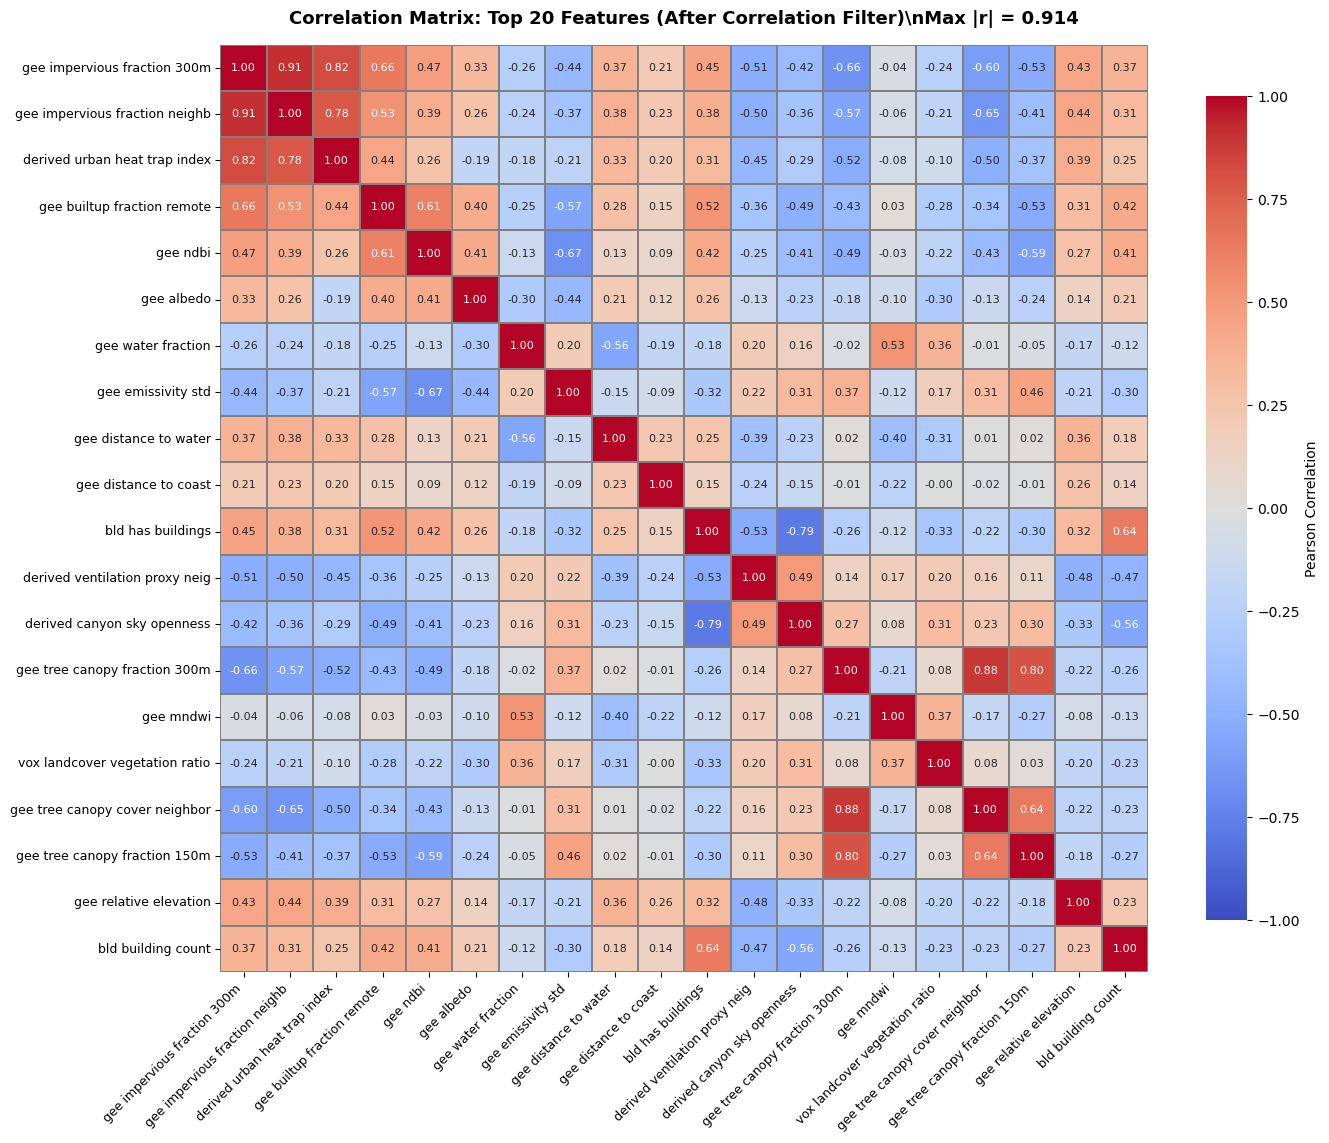

Saved figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/feature_correlation_heatmap.png
\nTop 20 Features by Correlation with UHI:


,Feature,r(UHI)
0,gee_impervious_fraction_300m,0.579
1,gee_impervious_fraction_neighbor_mean_300m,0.542
2,derived_urban_heat_trap_index,0.461
3,gee_builtup_fraction_remote,0.457
4,gee_ndbi,0.450
5,gee_albedo,0.435
6,gee_water_fraction,-0.421
7,gee_emissivity_std,-0.419
8,gee_distance_to_water,0.389
9,gee_distance_to_coast,0.337


Saved top feature correlations to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling/top20_feature_correlations.csv
\n✓ All 118 features have been filtered to ensure |r| < 0.92 among themselves


In [17]:
# Analyze correlation structure among most important features
# Use qa_dataset which has correlation filter applied (from Section 8)
remaining_features = qa_dataset.feature_columns

if len(remaining_features) > 1:
    # Compute correlations with target to identify important features
    corr_with_target = qa_dataset.frame[remaining_features + ['target_uhi_raw']].corr()['target_uhi_raw'].drop('target_uhi_raw')
    corr_with_target = corr_with_target.sort_values(key=abs, ascending=False)
    
    # Select top 20 most important features
    top_features = corr_with_target.head(20).index.tolist()
    
    # Compute correlation matrix for these features
    corr_matrix = qa_dataset.frame[top_features].corr()
    
    # Find max absolute correlation (excluding diagonal)
    corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    max_corr = corr_upper.abs().max().max()
    
    print(f"Correlation Analysis Summary:")
    print(f"  Total features in model: {len(remaining_features)}")
    print(f"  Features shown: Top 20 by |correlation with UHI|")
    print(f"  Max |correlation| among shown features: {max_corr:.4f}")
    print(f"  ✓ Multicollinearity check: {'PASSED' if max_corr < HIGH_CORRELATION_THRESHOLD else 'WARNING'}")
    print(f"    (Threshold: |r| < {HIGH_CORRELATION_THRESHOLD})\\n")
    
    # Correlation heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Clean feature names for display
    display_names = [f.replace('_scaled', '').replace('_', ' ')[:30] for f in top_features]
    corr_matrix_display = corr_matrix.copy()
    corr_matrix_display.index = display_names
    corr_matrix_display.columns = display_names
    
    sns.heatmap(corr_matrix_display, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, square=True, linewidths=0.3, linecolor='gray',
                cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8}, ax=ax,
                annot_kws={'size': 8})
    
    ax.set_title(f'Correlation Matrix: Top 20 Features (After Correlation Filter)\\nMax |r| = {max_corr:.3f}', 
                fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    fig_path = FIG_DIR / 'feature_correlation_heatmap.png'
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved figure to {fig_path}")
    
    # Summary table of feature-target correlations
    print("\\nTop 20 Features by Correlation with UHI:")
    corr_table = pd.DataFrame({
        'Feature': [f.replace('_scaled', '') for f in top_features],
        'r(UHI)': corr_with_target[top_features].values
    }).round(3)
    display(corr_table)
    corr_table_path = MODEL_RESULTS_DIR / 'top20_feature_correlations.csv'
    corr_table.to_csv(corr_table_path, index=False)
    print(f"Saved top feature correlations to {corr_table_path}")
    
    print(f"\\n✓ All {len(remaining_features)} features have been filtered to ensure |r| < {HIGH_CORRELATION_THRESHOLD} among themselves")
else:
    print("Insufficient features for correlation analysis")


## 9. MAUP sensitivity check
Compare 30 m production grid with 60/90 m sensitivity runs via stratified CV metrics.

In [18]:
from src.maup_resolution_comparison import collect_maup_metrics

maup_summary = collect_maup_metrics()
maup_summary = maup_summary.round({
    'r2_z_mean': 3,
    'r2_z_std': 3,
    'r2_raw_mean': 3,
    'r2_raw_std': 3,
    'rmse_raw_mean': 3,
    'mae_raw_mean': 3,
})

baseline = maup_summary.iloc[0]
maup_comparison = maup_summary.assign(
    delta_r2_z=(maup_summary['r2_z_mean'] - baseline['r2_z_mean']).round(3),
    delta_r2_raw=(maup_summary['r2_raw_mean'] - baseline['r2_raw_mean']).round(3),
    delta_mae=(maup_summary['mae_raw_mean'] - baseline['mae_raw_mean']).round(3),
)

maup_comparison


,grid_m,r2_z_mean,r2_z_std,r2_raw_mean,r2_raw_std,rmse_raw_mean,mae_raw_mean,delta_r2_z,delta_r2_raw,delta_mae
0,30,0.780,0.069,0.748,0.114,0.979,0.620,0.000,0.000,0.000
1,60,0.654,0.075,0.621,0.145,1.205,0.754,-0.126,-0.127,0.134
2,90,0.698,0.065,0.727,0.071,1.014,0.730,-0.082,-0.021,0.110


30 m remains the modelling resolution: coarser grids drop R² and increase MAE.